# Phase III: First ML Proof of Concept
## College Admissions Exploration 

- Team
- John Rotondo, Spring Yan, Anne Hu, Evan Li

Each **project group** will submit a single **jupyter notebook** which contains:

1. (3%) The implementation (using NumPy) of your first ML model as a function call to the cleaned data
2. (2%) A discussion of the preliminary results:
   - This may include checking of assumptions, generated plots/tables, measures of fit, or other attributes of the analysis
   - It does not have to be fully correct, but as a proof of concept must demonstrate that the group is close to completing the analysis

In [1]:
from secret import key
import requests
import json
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from collections import defaultdict

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import time

## Fetching & Cleaning Data 
Edit from phase 2: fetching data by state

In [2]:
abbrev_file = 'us-state-abbreviations.txt'
with open(abbrev_file, 'r') as file:
    # Read the file contents and split by lines
    state_abbreviations = [line.strip() for line in file.readlines()]

# Print the list of state abbreviations
print(state_abbreviations)

['AK', 'AL', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY']


In [3]:
def get_st_df(state, student_size=5000):
    # Base URL for the College Scorecard API
    url = "https://api.data.gov/ed/collegescorecard/v1/schools"
    
    # Your API key (replace with your own key)
    api_key = key
    
    fields = ['school.name',
              'latest.student.size',
              'school.state',
              'latest.admissions.admission_rate.overall',
              'latest.admissions.sat_scores.average.overall',
              'latest.admissions.act_scores.midpoint.cumulative',
              'latest.admissions.test_requirements',
              f'student.size__range={student_size}..']
    
    params = {
        'api_key': api_key,
        'school.state': state, 
        'fields': ','.join(fields), 
        'page': 0,  # Page number for pagination

        # ---- NEEED TO INCREASE THIS NUMBER!
        'per_page': 100  # Number of records per page (you can adjust this)
    }
    
    # Send the GET request
    response = requests.get(url, params=params)
    state_data = response.json()['results']

    return state_data 

In [4]:
def get_all_states_data(key, st_list):
    """ Iterates through all states and collects the data for each
    Params:
    - key = API key
    Returns:
    A dictionary with states as keys and corresponding school data as values """
    
    # Dictionary to store data for all states
    all_states_data = []
    
    # Loop through all states
    for state in st_list:
        print(f"Retrieving data for {state}...")
        state_data = get_st_df(state)
        
        all_states_data.append(state_data)
        
    # # Combine all state data into a single DataFrame
    # combined_df = pd.concat(all_states_data, ignore_index=True)
    return all_states_data

In [5]:
all_states = get_all_states_data(key, state_abbreviations)

Retrieving data for AK...
Retrieving data for AL...
Retrieving data for AZ...
Retrieving data for AR...
Retrieving data for CA...
Retrieving data for CO...
Retrieving data for CT...
Retrieving data for DE...
Retrieving data for FL...
Retrieving data for GA...
Retrieving data for HI...
Retrieving data for ID...
Retrieving data for IL...
Retrieving data for IN...
Retrieving data for IA...
Retrieving data for KS...
Retrieving data for KY...
Retrieving data for LA...
Retrieving data for ME...
Retrieving data for MD...
Retrieving data for MA...
Retrieving data for MI...
Retrieving data for MN...
Retrieving data for MS...
Retrieving data for MO...
Retrieving data for MT...
Retrieving data for NE...
Retrieving data for NV...
Retrieving data for NH...
Retrieving data for NJ...
Retrieving data for NM...
Retrieving data for NY...
Retrieving data for NC...
Retrieving data for ND...
Retrieving data for OH...
Retrieving data for OK...
Retrieving data for OR...
Retrieving data for PA...
Retrieving d

# Looking into the Fetched Data & NaN Values 

In [6]:
flattened_data = [school for state_data in all_states for school in state_data]

# Convert to a DataFrame
df = pd.DataFrame(flattened_data)

df

,latest.student.size,latest.admissions.admission_rate.overall,latest.admissions.sat_scores.average.overall,latest.admissions.act_scores.midpoint.cumulative,latest.admissions.test_requirements,school.name,school.state
0,6778,0.6532,NaN,NaN,3,University of Alaska Anchorage,AK
1,31,NaN,NaN,NaN,0,Alaska Bible College,AK
2,4010,NaN,NaN,22.0,0,University of Alaska Fairbanks,AK
3,964,0.6266,NaN,NaN,3,University of Alaska Southeast,AK
4,457,0.9931,NaN,NaN,3,Alaska Pacific University,AK
...,...,...,...,...,...,...,...
3606,1700,NaN,NaN,NaN,0,Northern Wyoming Community College District,WY
3607,1239,NaN,NaN,NaN,0,Western Wyoming Community College,WY
3608,45,NaN,NaN,NaN,0,Cheeks Beauty Academy,WY
3609,993,NaN,NaN,NaN,0,WyoTech,WY


In [7]:
# --- analyze NaN value count 
nan_count = df.isna().sum()
nan_count

latest.student.size                                    0
latest.admissions.admission_rate.overall            2308
latest.admissions.sat_scores.average.overall        2788
latest.admissions.act_scores.midpoint.cumulative    2847
latest.admissions.test_requirements                    0
school.name                                            0
school.state                                           0
dtype: int64

This count is quite concerning, and needs to be improved for the final project! 

In [8]:
# ---- need to rename the column names 
df.rename(columns={
    'latest.student.size': 'size',
    'latest.admissions.admission_rate.overall': 'admin_rate',
    'latest.admissions.sat_scores.average.overall': 'avg_sat',
    'latest.admissions.act_scores.midpoint.cumulative': 'midpoint_act',
    'latest.admissions.test_requirements': 'test_requirements',
    'school.name': 'name',
    'school.state': 'state',
}, inplace=True)

In [9]:
# --- convert numerical requirements to strings 
test_labels = {
        0: 'Not Required',
        1: 'Required',
        2: 'Recommended',
        3: 'Niether Rec. or Req.',
        4: 'Not Known'}

df['test_requirements'] = df['test_requirements'].map(
    lambda x: test_labels.get(x, 'Considered but not Req.')
)

In [1]:
def get_admin_rate_for_schools(state) -> int:
    state_df = pd.DataFrame()
    state_df = df[['admin_rate', 'state']].groupby(by='state').mean()
    
    if state is None:
        print("State is None.")
    else:
        return state_df.loc[state, 'admin_rate']

def get_avg_sat_for_schools(state) -> float:
    state_df = pd.DataFrame()
    state_df = df[['avg_sat', 'state']].groupby(by='state').mean()
    
    if state is None:
        print("State is None.")
    else:
        return state_df.loc[state, 'avg_sat']
    
def get_midpoint_act_for_schools(state) -> float:
    state_df = pd.DataFrame()
    state_df = df[['midpoint_act', 'state']].groupby(by='state').mean()
    
    if state is None:
        print("State is None.")
    else:
        return state_df.loc[state, 'midpoint_act']

def fill_missing_values(df) -> None:
    for index, row in df.iterrows():
        if pd.isna(row['admin_rate']):
            admin = get_admin_rate_for_schools(row['state'])
            df.at[index, 'admin_rate'] = admin
        if pd.isna(row['avg_sat']):
            sat = get_avg_sat_for_schools(row['state'])
            df.at[index, 'avg_sat'] = sat
        if pd.isna(row['midpoint_act']):
            act = get_midpoint_act_for_schools(row['state'])
            df.at[index, 'midpoint_act'] = act
    return df 

df = fill_missing_values(df)

NameError: name 'df' is not defined

## Testing to see missing value count 

In [10]:
# --- analyze NaN value count 
nan_count = df.isna().sum()
nan_count

size                    0
admin_rate           2308
avg_sat              2788
midpoint_act         2847
test_requirements       0
name                    0
state                   0
dtype: int64

In [11]:
# --- if drop the nan values
df.shape

(3611, 7)

In [12]:
# --- find unqiue test requirements
set(df['test_requirements'])

# -- now check if each category has a correpsonding test 
df[['admin_rate', 'avg_sat', 'midpoint_act', 'test_requirements']].groupby(by='test_requirements').mean()

,admin_rate,avg_sat,midpoint_act
test_requirements,,,
Considered but not Req.,0.721154,1171.062670,24.403427
Niether Rec. or Req.,0.757376,NaN,22.257143
Not Required,NaN,NaN,19.000000
Required,0.665220,1113.932584,22.623529


In [13]:
df[df['test_requirements'] == "Not Required"]

,size,admin_rate,avg_sat,midpoint_act,test_requirements,name,state
1,31,NaN,NaN,NaN,Not Required,Alaska Bible College,AK
2,4010,NaN,NaN,22.0,Not Required,University of Alaska Fairbanks,AK
5,202,NaN,NaN,NaN,Not Required,Alaska Vocational Technical Center,AK
6,268,NaN,NaN,NaN,Not Required,Alaska Career College,AK
7,162,NaN,NaN,NaN,Not Required,Ilisagvik College,AK
...,...,...,...,...,...,...,...
3605,889,NaN,NaN,NaN,Not Required,Northwest College,WY
3606,1700,NaN,NaN,NaN,Not Required,Northern Wyoming Community College District,WY
3607,1239,NaN,NaN,NaN,Not Required,Western Wyoming Community College,WY
3608,45,NaN,NaN,NaN,Not Required,Cheeks Beauty Academy,WY


In [14]:
len(set(df['state']))

df[['admin_rate', 'avg_sat', 'midpoint_act', 'state']].groupby(by='state').mean()

,admin_rate,avg_sat,midpoint_act
state,,,
AK,0.757633,NaN,22.000000
AL,0.759019,1126.388889,22.222222
AR,0.693389,1097.625000,22.714286
AZ,0.825907,1195.333333,22.500000
CA,0.616212,1294.000000,27.000000
CO,0.787481,1195.250000,24.466667
CT,0.691879,1231.210526,27.428571
DE,0.621300,1114.500000,29.000000
FL,0.688688,1168.478261,24.238095


# ML Model Implementation

## Regression Functions

In [15]:
def add_bias_column(X):
    """
    Args:
        X (array): can be either 1-d or 2-d
    
    Returns:
        Xnew (array): the same array, but 2-d with a column of 1's in the first spot
    """
    
    # If the array is 1-d
    if len(X.shape) == 1:
        Xnew = np.column_stack([np.ones(X.shape[0]), X])
    
    # If the array is 2-d
    elif len(X.shape) == 2:
        bias_col = np.ones((X.shape[0], 1))
        Xnew = np.hstack([bias_col, X])
        
    else:
        raise ValueError("Input array must be either 1-d or 2-d")

    return Xnew

In [16]:
def line_of_best_fit(X, y):
    """ Args: 
            X (array): either 1d or 2d with the predictor values 
            y (array): 1d and corresponding response values to 'X'
        Returns: 
            m (vector): vector with the slope and intercept term of the line of best fit"""
    # first call the add_bias_column for line of best fit calculation 
    Xnew = add_bias_column(X)
    
    # get the inverse of X transpose 
    XtXinv = np.linalg.inv(np.matmul(Xnew.T, Xnew))
    
    # get the vector with the slope and intercept term
    m = np.matmul(XtXinv, np.matmul(Xnew.T, y))

    return m

In [17]:
def linreg_predict(Xnew, ynew, m):
    """ Args: 
            Xnew (array): 1d or 2d with all predictor values, not including bias term
            ynew (array): 1d with all corresponding response values to 'Xnew'
            m (array): 1d array that contains the coefficents form the line_of_best_fit function
        Returns:
            result_dict (dct): A dct with 4 key-value pairs - ypreds, resids, mse, and r2"""
    
    # add bias column 
    Xnew = add_bias_column(Xnew)

    # fetch all the calculations
    ypreds = np.matmul(Xnew, m)

    resids = ynew - ypreds
    
    mse = np.mean(resids ** 2)

    # use of sklearn built-in r2_score function 
    r2 = r2_score(ynew, ypreds)

    # set up key-value pairs in the resulting dictionary 
    result_dict = {'ypreds': ypreds,
                  'resids': resids,
                  'mse': mse,
                  'r2': r2}

    return result_dict

## Simple Linear Regression
Average SAT to predict Admission Rate 

In [18]:
# use cleaned dataframe for regression model
drop_df = df.dropna()

# --- going to try to model without the "not required" schools 
drop_df = df[df["test_requirements"] != "Not Required"]
# drop_df = df[df["test_requirements"] == 'Required']

# filter by school size here 
drop_df = df[df["size"] >= 5000]


drop_df = df.dropna()

In [19]:
# check how many schools are in the data set w/ dropping NaN values & ignoring schools that are not required
drop_df.shape

(681, 7)

In [20]:
df.shape

(3611, 7)

In [21]:
# CROSS-FOLD VALIDATION
X_train, X_test, y_train, y_test = train_test_split(drop_df['avg_sat'], drop_df['admin_rate'], test_size=0.30, random_state=42)

# now fit model using line_of_best_fit function
m_train = line_of_best_fit(X_train, y_train)

# use test data to evaulate the model using the linreg_predict function, get "m" param from fitting the model above 
results = linreg_predict(X_test, y_test, m_train)

print(f"MSE: {results['mse']}, R^2: {results['r2']}")

MSE: 0.03620526144903808, R^2: 0.3137551044258331


In [22]:
# fit the regression model to the full data set 
m_full = line_of_best_fit(drop_df["avg_sat"], drop_df["admin_rate"])
slope = m_full[1]
intercept = m_full[0]


X = drop_df["avg_sat"]

y_pred = slope * X + intercept

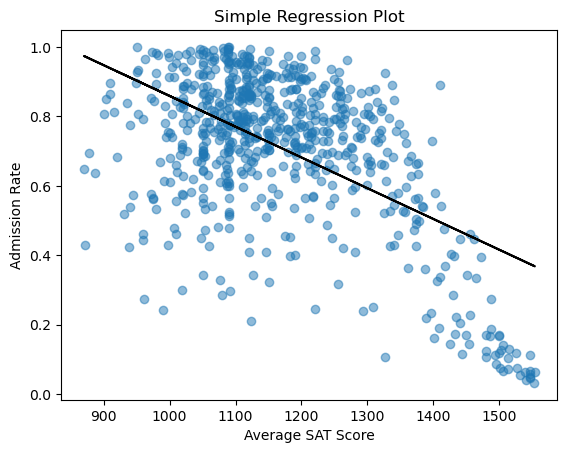

In [23]:
# --- INTIAL PLOT to see fit of the simple regression 
plt.scatter(X, drop_df["admin_rate"], label='data', alpha=0.5)

plt.plot(X, y_pred, color='black',label='linear fit')

plt.xlabel("Average SAT Score")
plt.ylabel("Admission Rate")
plt.title("Simple Regression Plot")
plt.show()

## Multiple Linear Regression
Average SAT, Midpoint ACT, & School Size to predict Admission Rate 

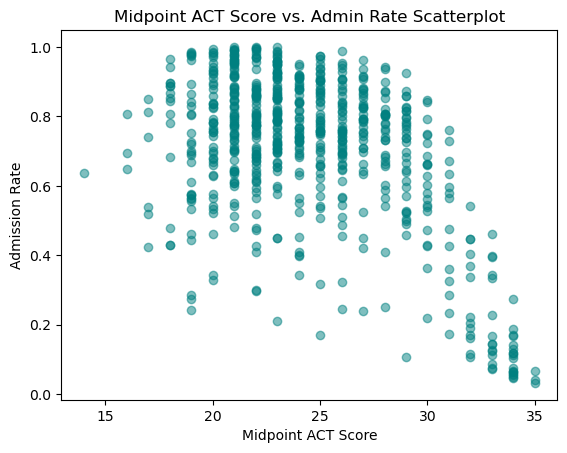

In [24]:
# Plot to see the linearity of the midpoint act 
plt.scatter(drop_df["midpoint_act"], drop_df["admin_rate"], color='teal', alpha=0.5)

plt.xlabel("Midpoint ACT Score")
plt.ylabel("Admission Rate")
plt.title("Midpoint ACT Score vs. Admin Rate Scatterplot")
plt.show()

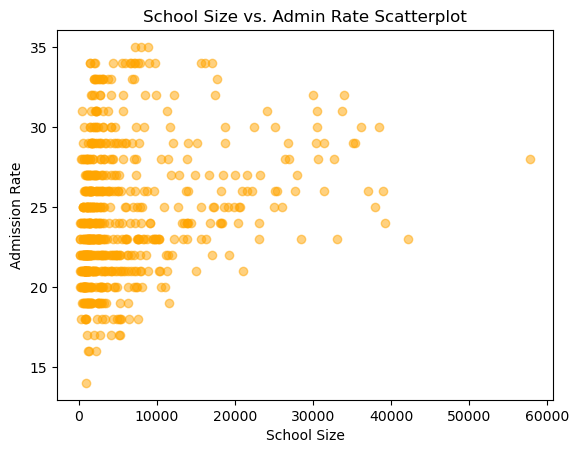

In [25]:
plt.scatter(drop_df["size"], drop_df["midpoint_act"], color = "orange", alpha=0.5)

# plt.plot(X, y_pred, color='black',label='linear fit')

plt.xlabel("School Size")
plt.ylabel("Admission Rate")
plt.title("School Size vs. Admin Rate Scatterplot")
plt.show()

In [26]:
# standarize the features! 

# define
x_feat_list = ['avg_sat', 'midpoint_act', 'size']
drop_df_num = drop_df[x_feat_list]

# scale the features using standardization
drop_df_scaled = pd.DataFrame()

for feat in drop_df_num.columns:
    drop_df_scaled[f'{feat}_scaled'] = ((drop_df_num[feat] - drop_df_num[feat].mean()) / drop_df_num[feat].std())

# convert dataframe to numpy array 
X_scaled = np.array(drop_df_scaled)
X_scaled[0]

array([-1.79242017, -1.5786016 , -0.05787269])

In [27]:
# CROSS-FOLD VALIDATION
X_train, X_test, y_train, y_test = train_test_split(X_scaled, drop_df['admin_rate'], test_size=0.30, random_state=42)

# now fit model using line_of_best_fit function
m_multi = line_of_best_fit(X_train, y_train)

# use test data to evaulate the model using the linreg_predict function, get "m" param from fitting the model above 
multi_results = linreg_predict(X_test, y_test, m_multi)

print(f"MSE: {multi_results['mse']}, R^2: {multi_results['r2']}")

MSE: 0.036241613323965145, R^2: 0.3130660805764026


Multiple regression model produced very similar results to the simple regression model with just average SAT!

## Polynomial Regression 

In [28]:
from sklearn.preprocessing import PolynomialFeatures

X_scores = np.array(drop_df['avg_sat']).reshape(-1,1)

In [ ]:
# --- WANT TO TRY MULTIPLE POLYNOMIAL REGRESSION MODEL

In [29]:
# setting up the quartic model
poly = PolynomialFeatures(3)
X_poly = poly.fit_transform(X_scores)

# drop the last bias column 
X_poly = X_poly[:, 1:]
X_poly

array([[9.20000000e+02, 8.46400000e+05, 7.78688000e+08],
       [1.29100000e+03, 1.66668100e+06, 2.15168517e+09],
       [1.25900000e+03, 1.58508100e+06, 1.99561698e+09],
       ...,
       [1.15000000e+03, 1.32250000e+06, 1.52087500e+09],
       [1.09000000e+03, 1.18810000e+06, 1.29502900e+09],
       [1.12000000e+03, 1.25440000e+06, 1.40492800e+09]])

In [30]:
# perform single-fold cross validation 
Xtrain, Xtest, ytrain, ytest = train_test_split(X_poly, drop_df['admin_rate'], test_size=0.30, random_state=42)

# fit to training data 
m_poly = line_of_best_fit(Xtrain, ytrain)

# pass testing data 
poly_rlst = linreg_predict(Xtest, ytest, m_poly)


print(f"MSE: {poly_rlst['mse']}, R^2: {poly_rlst['r2']}")

MSE: 0.02555672694952048, R^2: 0.5155904773294451


The polynomial regression model does not improve the R^2 by much.

# Dicussion of Results
- This may include checking of assumptions, generated plots/tables, measures of fit, or other attributes of the analysis
- It does not have to be fully correct, but as a proof of concept must demonstrate that the group is close to completing the analysis

**Assumptions Check**
- Check for **Independence** by analyzing index vs residuals for independence among errors
- Check for **Constant Variance** by analyzing fitted value against residuals and look for randomness
- Check for **Normality** by analyzing a histogram plot of residuals and look to see if it follows a straight line

### Linear Regression:

Based on the plots below...

**Independence:** Looks relatively good as there is no clear pattern; there seems to be a random scattering.

**Constant Variance:** The constant variance is quite suspcious as there is a clear pattern and spike among the residuals.

**Normality:** The historgram shows a relatively normal distrubtion with a slight skewness to the left. 

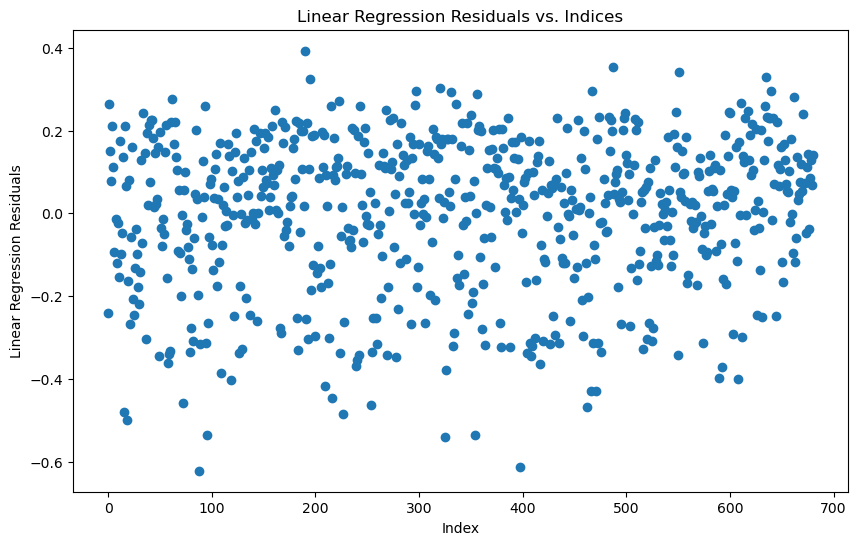

In [31]:
# Check for independence: Simple linear regression

#Get the result predictions for the whole dataset.
pred = linreg_predict(drop_df['avg_sat'], drop_df['admin_rate'], m_train)

#Get the residuals
residuals = pred['resids']

#Independence
plt.figure(figsize=(10, 6))
plt.scatter(pd.Series(range(len(drop_df['avg_sat']))), residuals)
plt.xlabel('Index')
plt.ylabel('Linear Regression Residuals')
plt.title('Linear Regression Residuals vs. Indices')
plt.show()

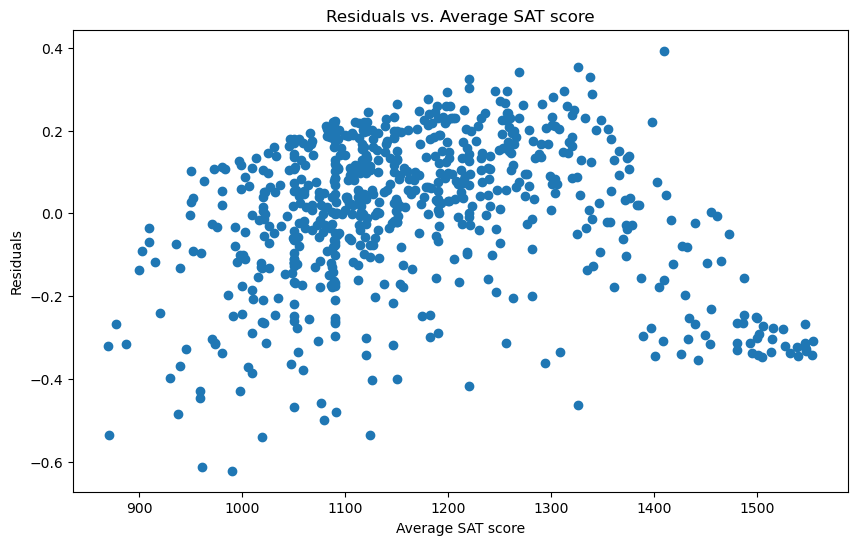

In [32]:
# Check for Constant variance: Simple linear regression

plt.figure(figsize=(10, 6))
plt.scatter(drop_df['avg_sat'], residuals)
plt.xlabel('Average SAT score')
plt.ylabel('Residuals')
plt.title('Residuals vs. Average SAT score')
plt.show()


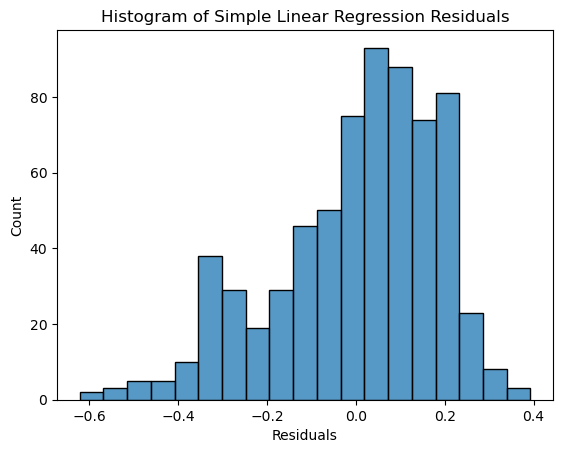

In [33]:
# Check for Normality: Simple linear regression
sns.histplot(residuals, kde=False)
plt.xlabel("Residuals")
plt.title("Histogram of Simple Linear Regression Residuals")
plt.show()


## Multiple Linear Regression:
Based on the plots below...

**Independence:** Looks relatively good as there is no clear pattern; there seems to be a random scattering.

**Constant Variance:** The constant variance for the avg sat scores is quite suspcious as there is a clear pattern and spike among the residuals. Same goes for the midpoint ACT and size features, with the constant variance between the school size and reisuals having a major clumping. This could be attributed to the school size filter that was applied to the data so there is not great variation in school size among the colleges in the data set. 

**Normality:** The historgram shows a relatively normal distrubtion with a slight skewness to the left. 

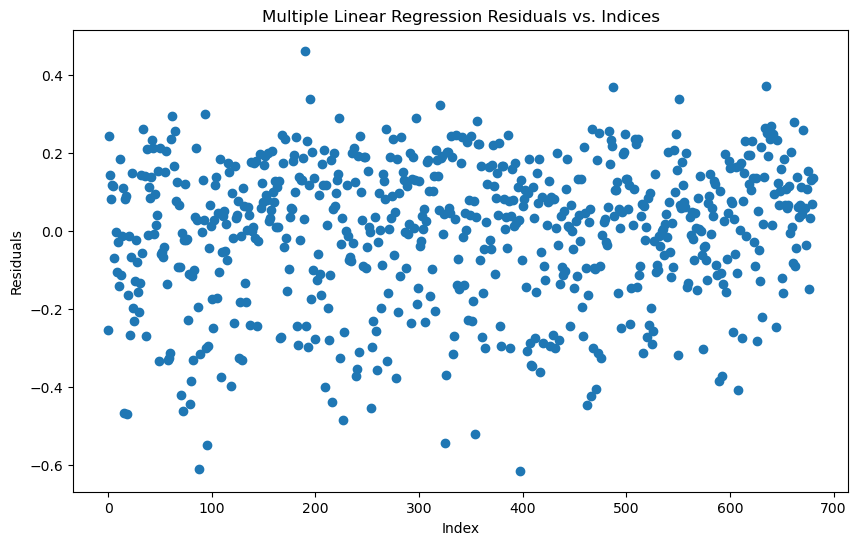

In [34]:
# Check for independence: Multiple linear regression

#Get predictions for full set of data
multi_results = linreg_predict(X_scaled, drop_df['admin_rate'], m_multi)

#Get the residuals
multi_residuals = multi_results['resids']

#Independence
plt.figure(figsize=(10, 6))
plt.scatter(pd.Series(range(len(multi_residuals))), multi_residuals)
plt.xlabel('Index')
plt.ylabel('Residuals')
plt.title('Multiple Linear Regression Residuals vs. Indices')
plt.show()

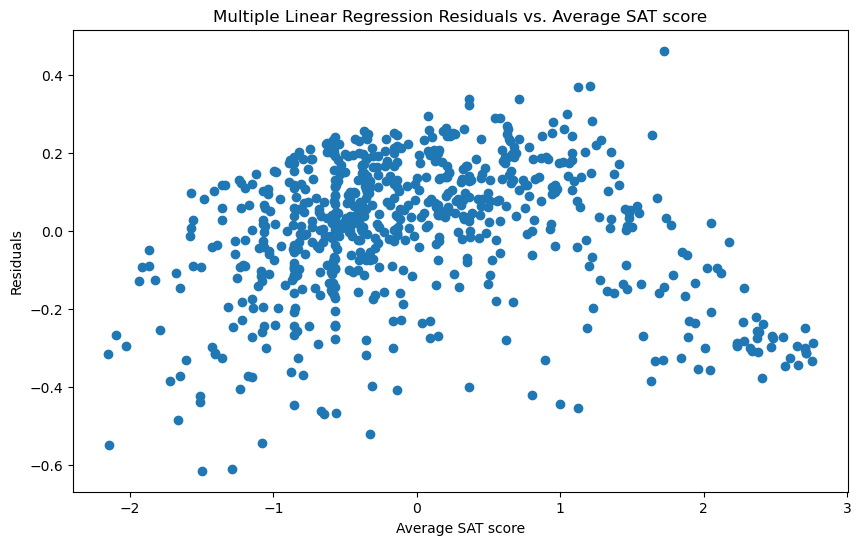

In [35]:
# Check for Constant variance: Multiple linear regression

plt.figure(figsize=(10, 6))
plt.scatter(drop_df_scaled['avg_sat_scaled'], multi_residuals) 
plt.xlabel('Average SAT score')
plt.ylabel('Residuals')
plt.title('Multiple Linear Regression Residuals vs. Average SAT score')
plt.show()

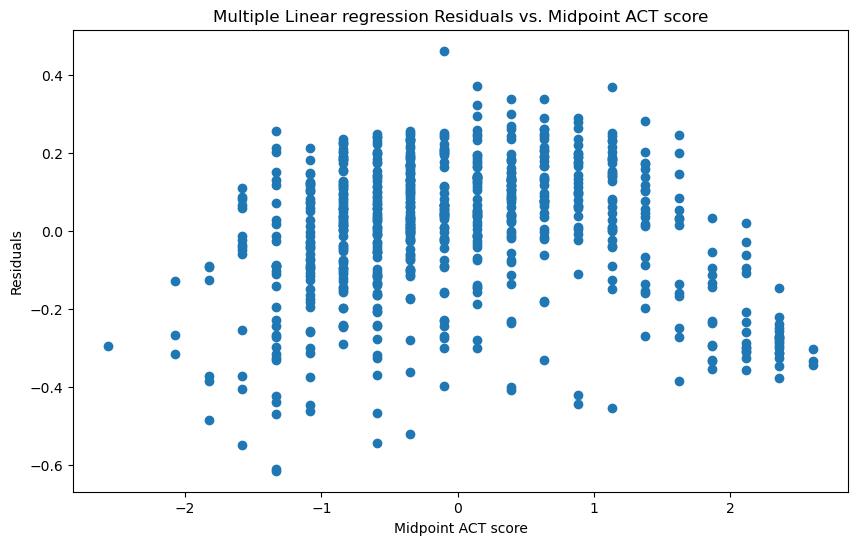

In [36]:
# Check for Constant variance: Multiple linear regression

plt.figure(figsize=(10, 6))
plt.scatter(drop_df_scaled['midpoint_act_scaled'], multi_residuals) 
plt.xlabel('Midpoint ACT score')
plt.ylabel('Residuals')
plt.title('Multiple Linear regression Residuals vs. Midpoint ACT score')
plt.show()

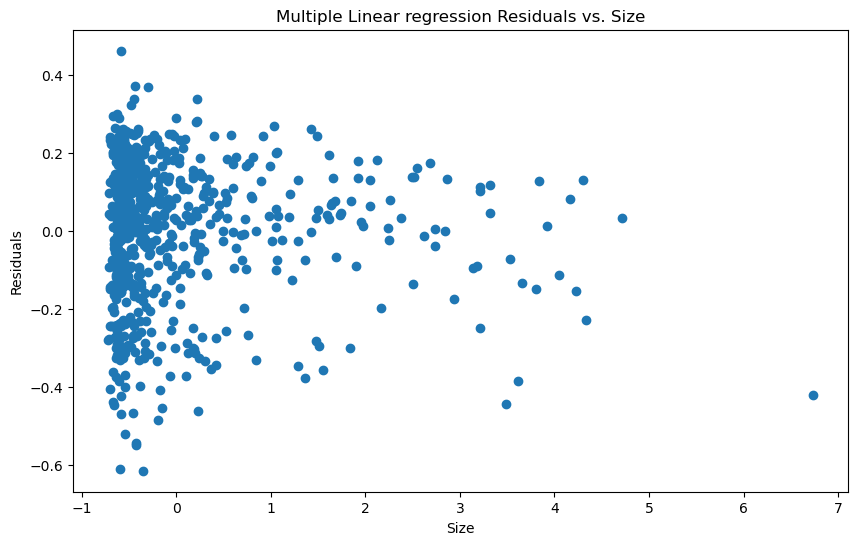

In [37]:
# Check for Constant variance: Multiple linear regression

plt.figure(figsize=(10, 6))
plt.scatter(drop_df_scaled['size_scaled'], multi_residuals) 
plt.xlabel('Size')
plt.ylabel('Residuals')
plt.title('Multiple Linear regression Residuals vs. Size')
plt.show()

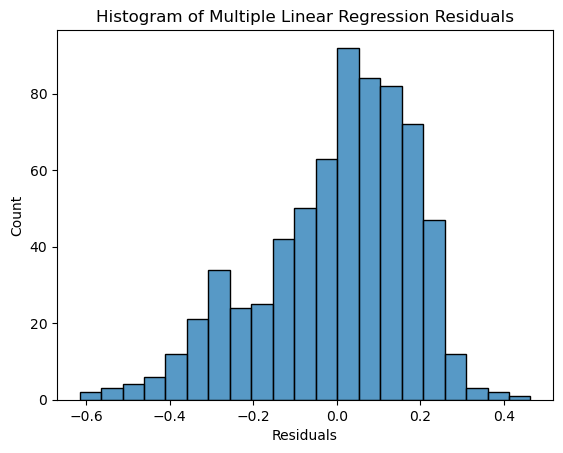

In [38]:
# Check for Normality: Multiple linear regression

sns.histplot(multi_residuals, kde=False)
plt.xlabel("Residuals")
plt.title("Histogram of Multiple Linear Regression Residuals")
plt.show()

## Polynomial Regression: 
Based on the plots below...

**Independence:** Looks relatively ok as there is no clear pattern; there seems to be a random scattering. However, there seems to be a concentration of points along the residuals near 0 - could this mean overfitted? 

**Constant Variance:** The constant variance for the avg sat scores is quite suspcious as there is a clear pattern and weird curves/concentrations among the residuals. 

**Normality:** The historgram shows a relatively normal distrubtion with a slight skewness to the left. 

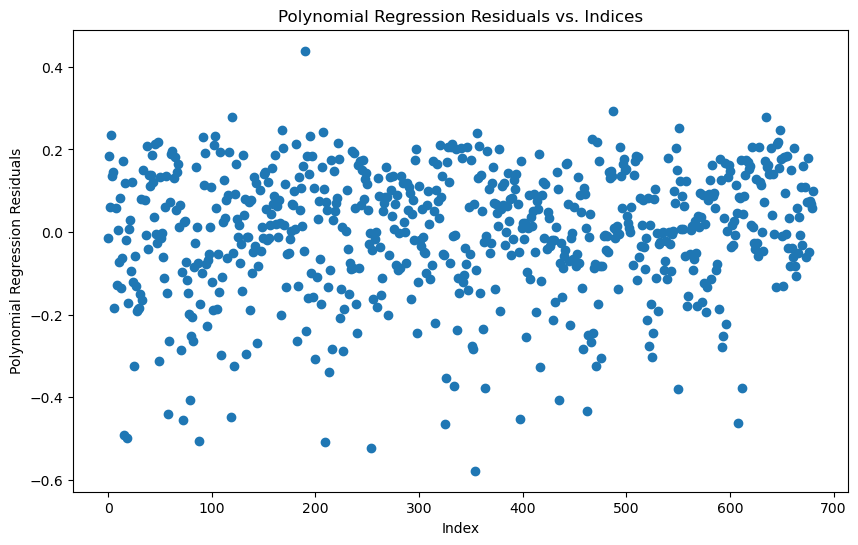

In [39]:
# Check for independence: Polynomial regression

# Get the result predictions for the whole dataset.
poly_rlst = linreg_predict(X_poly, drop_df['admin_rate'], m_poly)

# Get the residuals
poly_residuals = poly_rlst['resids']

#Independence
plt.figure(figsize=(10, 6))
plt.scatter(pd.Series(range(len(poly_residuals))), poly_residuals)
plt.xlabel('Index')
plt.ylabel('Polynomial Regression Residuals')
plt.title('Polynomial Regression Residuals vs. Indices')
plt.show()

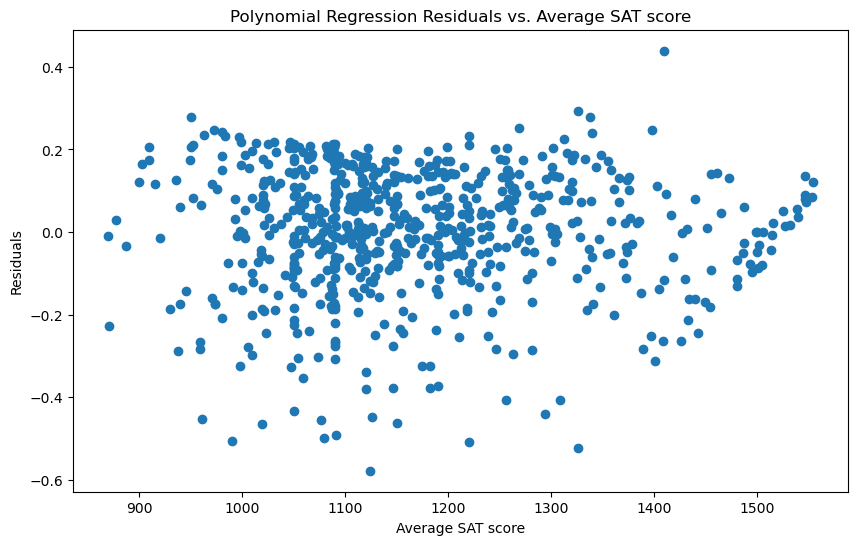

In [40]:
# Check for Constant variance: Polynomial regression
plt.figure(figsize=(10, 6))
plt.scatter(X_scores , poly_residuals) 
plt.xlabel('Average SAT score')
plt.ylabel('Residuals')
plt.title('Polynomial Regression Residuals vs. Average SAT score')
plt.show()

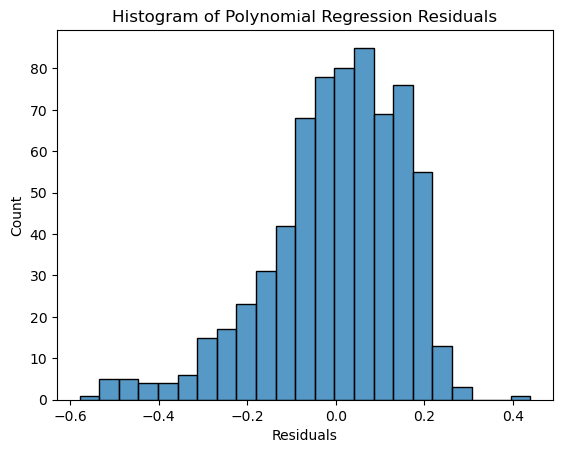

In [41]:
# Check for Normality: Polynomial regression

sns.histplot(poly_residuals, kde=False)
plt.xlabel("Residuals")
plt.title("Histogram of Polynomial Regression Residuals")
plt.show()

## Next Steps: 
**Regression Improvements** 

While the fairly low R^2 scores for each regression model were fairly worrisome the assumption checks gave us greater insight into our data. Based on the assumption checks and the ability to improve the models in the future, we have decided to explore the multiple and polynomial regression models further. Some improvements we could make are experimenting with transformation as well as adding different features to the multiple regression model. This could help boost the constant variance and normality assumptions. 

We also want to be intentional about the features we add to the regression model so as to not just boost the R^2 score, but substantially contribute to our research questions. Once these next steps are exhausted, we will (if the results hold) dive deeper into explaining why the regression model is ineffective. This could perhaps be more insightful than an effective model as it could re-examine the impact average test scores have on a college’s admin rate. 

**Data Fetching** 

Another major analysis we want to do is compare the regression models based on how we treat the missing data. Currently, we are replacing the missing test scores with their respective state averages which could be skewing the regression model. If you look at our first simple regression plot, there seems to be a high concentration of points at the top of the graph which could be due to the amount of missing values we are replacing. When we got an intial NaN Value count, over 70% of the data has a missing value in either the avg_sat, midpoint_act, and admin_rate columns. This is quite concerning and also signals why the is such high concentration of data is certain areas, as they are being replaced with state averages. 

Therefore, we would like to also run the same regression analysis using data that drops colleges with missing test data and use that as a benchmark comparison. Perhaps by dropping the rows, with missing data, we could still use a sufficient dataset to run regression analysis. I would also think about getting rid of the school size filter and maybe just lowering it to 1000. This could possibly improve the ability to use school size to help predict admission rate. 

**Second ML Model**

Looking forward to our second ML model, we want to potentially explore a classification model possibly using average test scores to classify states or regions (higher-level feature). Using a classification model can offer us different insights to a regression model, and can perhaps give us more insight into the research questions we are looking to answer. More of this to come in our final project submission! 
